In [1]:
# # Gemma-3-270M + LoRA (PEFT) for Claim–Evidence Sequence Classification
# JSONL fields:
# - claim (str)
# - evidence_sentences (str)
# - label (int) with 0 = supports, 1 = refutes

!pip -q install "transformers>=4.44.0" "datasets>=2.19.0" "accelerate>=0.34.0" "peft>=0.13.0" "bitsandbytes>=0.43.0" "scikit-learn>=1.3.0"

import os, random, math, json, torch
from datetime import datetime
from dataclasses import dataclass
from typing import Dict, Any

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig,
)

from peft import LoraConfig, get_peft_model, TaskType

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- GPU & dtype helper ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU:", gpu_name)
else:
    print("Running on CPU (OK for debugging, but use GPU for training).")



# Prefer bfloat16 if available (A100, T4 supports fp16; bfloat16 often works on T4 recent drivers)
bf16_available = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
dtype = torch.bfloat16 if bf16_available else torch.float16
print("Using dtype:", dtype)

Device: cuda
GPU: Tesla T4
Using dtype: torch.bfloat16


In [4]:

# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Point to your JSONL in Drive
DATA_FILE = "/content/drive/MyDrive/fever_train_ready.jsonl"  # <-- change if needed
assert os.path.exists(DATA_FILE), f"File not found: {DATA_FILE}"

# --- Load dataset ---
# JSONL expected per-line: {"claim": "...", "evidence_sentences": "...", "label": 0|1}
raw_ds = load_dataset("json", data_files=DATA_FILE, split="train")

# Basic sanity checks / preview
print(raw_ds[0])
print("Total examples:", len(raw_ds))

# Train/val split
ds = raw_ds.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = ds["train"], ds["test"]
print("Train:", len(train_ds), "Val:", len(val_ds))

In [ ]:
# --- Preprocessing / tokenization ---

# --- Model & tokenizer ---
MODEL_NAME = "google/gemma-3-270m"

# 4-bit loading to save VRAM (great for Colab T4)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)

id2label = {0: "supports", 1: "refutes"}
label2id = {"supports": 0, "refutes": 1}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    quantization_config=bnb_config,
    torch_dtype=dtype,
    device_map="auto",
)


In [8]:
from huggingface_hub import login
from google.colab import userdata

# Log in to Hugging Face
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("Successfully logged in to Hugging Face.")
except Exception as e:
    print(f"Failed to log in to Hugging Face: {e}")
    print("Please ensure you have added your Hugging Face token to Colab secrets named 'HF_TOKEN'.")

Successfully logged in to Hugging Face.


In [ ]:
MAX_LEN = 512  # adjust if your evidence is long; Gemma-3 supports long contexts, but keep training practical

label_map = {
    "SUPPORTS": 0,
    "Supports": 0,
    "supports": 0,
    0: 0,
    "REFUTES": 1,
    "Refutes": 1,
    "refutes": 1,
    1: 1
}

def make_text(claim: str, evidence: str) -> str:
    return f"Claim: {claim}\nEvidence: {evidence}\nTask: Does the evidence support the claim? Answer with 'supports' or 'refutes'."

def preprocess(batch):
    texts = [make_text(c, e) for c, e in zip(batch["claim"], batch["evidence_sentences"])]
    enc = tokenizer(texts, truncation=True, max_length=MAX_LEN)
    # ✅ Map labels safely (handles both strings and ints)
    enc["labels"] = [label_map.get(x, 1) for x in batch["label"]]
    return enc
tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

# Data collator pads dynamically per-batch (avoids size mismatches)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

In [12]:
# --- Apply LoRA (PEFT) ---
# Target modules cover attention + MLP proj layers commonly used in Gemma/LLaMA-like blocks.
# This keeps the classifier head intact while adapting the base transformer efficiently.
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

model = get_peft_model(model, lora_config)

# Show trainable params (should be small)
def print_trainable_params(m):
    trainable, total = 0, 0
    for _, p in m.named_parameters():
        num = p.numel()
        total += num
        if p.requires_grad:
            trainable += num
    pct = 100 * trainable / total
    print(f"Trainable params: {trainable:,} / {total:,} ({pct:.2f}%)")
print_trainable_params(model)

Trainable params: 3,798,272 / 221,762,688 (1.71%)


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary", pos_label=1)
    prec = precision_score(labels, preds, average="binary", pos_label=1)
    rec = recall_score(labels, preds, average="binary", pos_label=1)
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}


In [14]:
import transformers
print(transformers.__version__)

4.57.1


In [15]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"/content/gemma3_lora_claims_cls_{timestamp}"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-4,                 # LoRA usually trains well with a slightly higher LR
    per_device_train_batch_size=16,     # adjust if OOM; try 8 if memory is tight
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,      # increase to fit larger batches if desired
    num_train_epochs=1,
    weight_decay=0.05,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    bf16=(dtype == torch.bfloat16),
    fp16=(dtype == torch.float16),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2198529188.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:

# --- Train ---
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.291800,0.303256,0.881500,0.880243,0.886965,0.873621


TrainOutput(global_step=1125, training_loss=0.4624725833468967, metrics={'train_runtime': 2434.7327, 'train_samples_per_second': 7.393, 'train_steps_per_second': 0.462, 'total_flos': 5051846021578752.0, 'train_loss': 0.4624725833468967, 'epoch': 1.0})

In [17]:
# --- Evaluate ---
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.303255558013916,
 'eval_accuracy': 0.8815,
 'eval_f1': 0.8802425467407782,
 'eval_precision': 0.8869653767820774,
 'eval_recall': 0.8736208625877633,
 'eval_runtime': 101.2831,
 'eval_samples_per_second': 19.747,
 'eval_steps_per_second': 1.234,
 'epoch': 1.0}

In [18]:
# Saving LoRA adapter (small!) is usually enough:
ADAPTER_DIR = os.path.join(OUTPUT_DIR, "lora_adapter")
trainer.model.save_pretrained(ADAPTER_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved LoRA adapter to:", ADAPTER_DIR)

Saved LoRA adapter to: /content/gemma3_lora_claims_cls_20251106_092826/lora_adapter


In [19]:

# (Optional) Merge LoRA into base weights and save full model (larger; slower).
# Useful if you’ll deploy without PEFT at inference time.
MERGED_DIR = os.path.join(OUTPUT_DIR, "merged_full_model")
do_merge = False  # set True to export a fully merged model
if do_merge:
    base = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
        torch_dtype=dtype,
        device_map="auto",
        quantization_config=None  # load in full precision before merging
    ).to(device)
    # Load adapter into fresh base, then merge
    from peft import PeftModel
    peft_loaded = PeftModel.from_pretrained(base, ADAPTER_DIR)
    merged = peft_loaded.merge_and_unload()
    os.makedirs(MERGED_DIR, exist_ok=True)
    merged.save_pretrained(MERGED_DIR)
    tokenizer.save_pretrained(MERGED_DIR)
    print("Merged full model saved to:", MERGED_DIR)


In [20]:
# --- Quick inference helper ---
def classify(claim: str, evidence_sentences: str) -> Dict[str, Any]:
    model.eval()
    text = make_text(claim, evidence_sentences)
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(model.device)
    with torch.no_grad():
        out = model(**enc)
        logits = out.logits[0].float().cpu()
        pred_id = int(torch.argmax(logits).item())
        score = float(torch.softmax(logits, dim=-1)[pred_id].item())
        return {"label_id": pred_id, "label": id2label[pred_id], "score": score}

# Example:
example = classify(
    claim="The sun rises in the east.",
    evidence_sentences="Due to Earth's west-to-east rotation, observers see the sun rise in the east."
)
example

{'label_id': 0, 'label': 'supports', 'score': 0.8423450589179993}

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

In [25]:
fine_preds = trainer.predict(tokenized_val)
fine_y_true = fine_preds.label_ids
fine_y_pred = np.argmax(fine_preds.predictions, axis=1)

In [28]:
print("=== Model After Fine-tuning === \n")
print(classification_report(fine_y_true, fine_y_pred, target_names=["SUPPORTS", "REFUTES"],digits=4))

=== Model After Fine-tuning === 

              precision    recall  f1-score   support

    SUPPORTS     0.8762    0.8893    0.8827      1003
     REFUTES     0.8870    0.8736    0.8802       997

    accuracy                         0.8815      2000
   macro avg     0.8816    0.8815    0.8815      2000
weighted avg     0.8816    0.8815    0.8815      2000



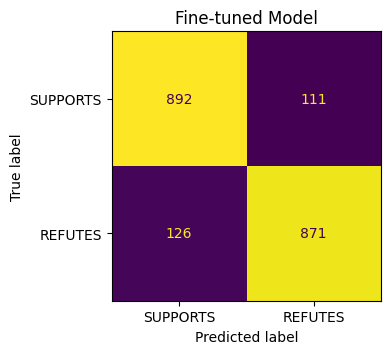

In [30]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) # Create a single subplot

cm_fine = confusion_matrix(fine_y_true, fine_y_pred)
ConfusionMatrixDisplay(cm_fine, display_labels=["SUPPORTS", "REFUTES"]).plot(ax=ax, colorbar=False) # Plot on the single axis
ax.set_title("Fine-tuned Model") # Set title for the single plot

plt.tight_layout()
plt.show()

In [21]:
!zip -r gemma_archive.zip /content/gemma3_lora_claims_cls_20251106_092826


  adding: content/gemma3_lora_claims_cls_20251106_092826/ (stored 0%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/ (stored 0%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/rng_state.pth (deflated 26%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/trainer_state.json (deflated 75%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/training_args.bin (deflated 53%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/tokenizer.model (deflated 52%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/special_tokens_map.json (deflated 77%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/README.md (deflated 66%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/scheduler.pt (deflated 62%)
  adding: content/gemma3_lora_claims_cls_20251106_092826/checkpoint-1125/adapter_model.safetensors (deflated 7%)
 

In [22]:
from google.colab import files

files.download('gemma_archive.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>